# Data Understanding and Preprocessing

# data exploration

In [1]:
import pandas as pd

# Load the dataset to analyze its contents
dataset = pd.read_csv('fraud_detection_data.csv')

# Display the first few rows of the dataset for analysis
dataset.head()


,Transaction ID,Customer ID,Transaction Date,Transaction Amount,Merchant,Location,Transaction Type,Card Type,Is Fraudulent
0,90023589-2ef8-43e7-807a-b4ab92fcc2a4,5d7358c2-ede9-488a-96e4-fa78a9d9d6db,2024-03-05 15:53:49,231.55,Torres-Sanchez,West Adam,Online Purchase,MasterCard,Yes
1,3eb2e762-9525-4c33-a022-a47e3da3ec5d,0aac2ab4-f920-428a-939a-78ff9858c13d,2024-07-04 01:00:25,1485.69,"Brandt, Ross and Butler",New Benjaminbury,In-Store Purchase,Discover,Yes
2,12d58e99-92d7-46f3-8ac0-e01ac86c15ec,4d6ee059-5df1-4323-8484-2f04aae3d6b3,2024-01-14 00:18:53,497.33,Delgado LLC,Lake Jamieberg,ATM Withdrawal,Amex,Yes
3,e9cac917-d336-4629-9baa-f8c19691cb80,d7709d08-fa3c-419c-b2fb-bc9ef2997ef9,2023-12-09 03:06:54,287.68,"Smith, Mcdonald and Cruz",Lake James,In-Store Purchase,Visa,Yes
4,acb39efa-d3c7-4bae-9b6c-9cda5ed79503,e505e3e6-7982-4c7f-b0b1-26a0b6d59d31,2024-02-17 03:22:55,213.97,Huff Ltd,Lake Anthony,In-Store Purchase,Discover,No


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [3]:
# Check the distribution of fraudulent vs. legitimate transactions
fraud_distribution = dataset['Is Fraudulent'].value_counts()
print(fraud_distribution)

Yes    183
No     180
Name: Is Fraudulent, dtype: int64


# Handle any missing or inconsistent data

In [4]:
import warnings
# Check for missing or inconsistent data
missing_data = dataset.isnull().sum()
print(missing_data)

# Handling missing data (example: filling missing values with median)
dataset.fillna(dataset.median(), inplace=True)
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Transaction ID        0
Customer ID           0
Transaction Date      0
Transaction Amount    0
Merchant              0
Location              0
Transaction Type      0
Card Type             0
Is Fraudulent         0
dtype: int64


# Convert categorical variables into numerical representations

In [5]:
# Convert categorical columns to numerical using one-hot encoding
dataset_encoded = pd.get_dummies(dataset, columns=['Merchant', 'Location', 'Transaction Type', 'Card Type'], drop_first=True)

# Display the first few rows of the newly encoded dataset
print(dataset_encoded.head())


                         Transaction ID                           Customer ID  \
0  90023589-2ef8-43e7-807a-b4ab92fcc2a4  5d7358c2-ede9-488a-96e4-fa78a9d9d6db   
1  3eb2e762-9525-4c33-a022-a47e3da3ec5d  0aac2ab4-f920-428a-939a-78ff9858c13d   
2  12d58e99-92d7-46f3-8ac0-e01ac86c15ec  4d6ee059-5df1-4323-8484-2f04aae3d6b3   
3  e9cac917-d336-4629-9baa-f8c19691cb80  d7709d08-fa3c-419c-b2fb-bc9ef2997ef9   
4  acb39efa-d3c7-4bae-9b6c-9cda5ed79503  e505e3e6-7982-4c7f-b0b1-26a0b6d59d31   

      Transaction Date  Transaction Amount Is Fraudulent  \
0  2024-03-05 15:53:49              231.55           Yes   
1  2024-07-04 01:00:25             1485.69           Yes   
2  2024-01-14 00:18:53              497.33           Yes   
3  2023-12-09 03:06:54              287.68           Yes   
4  2024-02-17 03:22:55              213.97            No   

   Merchant_Adams-Gutierrez  Merchant_Adkins, Figueroa and Parker  \
0                         0                                     0   
1             

# Balance the dataset

In [6]:
# Import SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assume dataset_encoded is already defined

# Separate the features and the target variable
X = dataset_encoded.drop('Is Fraudulent', axis=1)
y = dataset_encoded['Is Fraudulent'].apply(lambda x: 1 if x == 'Yes' else 0)  # Convert 'Yes' to 1 and 'No' to 0

# Identify columns with non-numeric values
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# Apply Label Encoding to 'Transaction ID' and 'Customer ID'
label_encoders = {}
for col in ['Transaction ID', 'Customer ID']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Save the encoder for later use

# Convert 'Transaction Date' to numerical format (e.g., Unix timestamp or extract features like year/month)
X['Transaction Date'] = pd.to_datetime(X['Transaction Date'])
X['Transaction Year'] = X['Transaction Date'].dt.year
X['Transaction Month'] = X['Transaction Date'].dt.month
X['Transaction Day'] = X['Transaction Date'].dt.day
X = X.drop('Transaction Date', axis=1)  # Drop the original date column after extracting features

# Now apply SMOTE to the numeric data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the distribution after resampling
print(y_resampled.value_counts())



Non-numeric columns: Index(['Transaction ID', 'Customer ID', 'Transaction Date'], dtype='object')
1    183
0    183
Name: Is Fraudulent, dtype: int64


# Feature Engineering

In [7]:
# Convert 'Transaction Date' to datetime for easier manipulation
dataset_encoded['Transaction Date'] = pd.to_datetime(dataset['Transaction Date'])

# 1. Transaction Frequency by Customer
# Create a feature for the number of transactions each customer has made
transaction_frequency = dataset_encoded.groupby('Customer ID')['Transaction ID'].transform('count')
dataset_encoded['Transaction Frequency'] = transaction_frequency

# 2. Average Transaction Amount by Customer
# Calculate the average transaction amount for each customer
average_transaction_amount = dataset_encoded.groupby('Customer ID')['Transaction Amount'].transform('mean')
dataset_encoded['Avg Transaction Amount'] = average_transaction_amount

# 3. Time of Day
# Extract hour from 'Transaction Date' to create a feature for the time of day
dataset_encoded['Transaction Hour'] = dataset_encoded['Transaction Date'].dt.hour

# 4. Interaction between Features (example: interaction between transaction type and transaction amount)
dataset_encoded['Amount_Type_Interaction'] = dataset_encoded['Transaction Amount'] * dataset_encoded['Transaction Type_Online Purchase']

# Check the updated dataset
print(dataset_encoded.head())


                         Transaction ID                           Customer ID  \
0  90023589-2ef8-43e7-807a-b4ab92fcc2a4  5d7358c2-ede9-488a-96e4-fa78a9d9d6db   
1  3eb2e762-9525-4c33-a022-a47e3da3ec5d  0aac2ab4-f920-428a-939a-78ff9858c13d   
2  12d58e99-92d7-46f3-8ac0-e01ac86c15ec  4d6ee059-5df1-4323-8484-2f04aae3d6b3   
3  e9cac917-d336-4629-9baa-f8c19691cb80  d7709d08-fa3c-419c-b2fb-bc9ef2997ef9   
4  acb39efa-d3c7-4bae-9b6c-9cda5ed79503  e505e3e6-7982-4c7f-b0b1-26a0b6d59d31   

     Transaction Date  Transaction Amount Is Fraudulent  \
0 2024-03-05 15:53:49              231.55           Yes   
1 2024-07-04 01:00:25             1485.69           Yes   
2 2024-01-14 00:18:53              497.33           Yes   
3 2023-12-09 03:06:54              287.68           Yes   
4 2024-02-17 03:22:55              213.97            No   

   Merchant_Adams-Gutierrez  Merchant_Adkins, Figueroa and Parker  \
0                         0                                     0   
1                   

# Model Building

# Splitting the Dataset

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (256, 725)
Test set size: (110, 725)


# Train Logistic Regression Model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Initialize the model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)
# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log_reg))
print(f"AUC-ROC: {roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])}")


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.59      0.48      0.53        56
           1       0.55      0.65      0.59        54

    accuracy                           0.56       110
   macro avg       0.57      0.57      0.56       110
weighted avg       0.57      0.56      0.56       110

AUC-ROC: 0.5572089947089947


# Train Random Forest Model

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_clf = RandomForestClassifier(random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)
# Make predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"AUC-ROC: {roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])}")


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.57      0.61      0.59        56
           1       0.56      0.52      0.54        54

    accuracy                           0.56       110
   macro avg       0.56      0.56      0.56       110
weighted avg       0.56      0.56      0.56       110

AUC-ROC: 0.5725859788359787


# Fraud Detection System Design

# Real-time Fraud Detection System

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Example dataset for fraud detection (you can replace it with your actual dataset)
data = {
    'transaction_amount': [100, 1500, 400, 200, 10000],
    'transaction_hour': [10, 14, 22, 11, 2],  # Hour of the day (24-hour format)
    'transaction_type': ['Online Purchase', 'In-Store Purchase', 'Online Purchase', 'ATM Withdrawal', 'Online Purchase'],
    'card_type': ['Visa', 'MasterCard', 'Visa', 'Amex', 'Discover'],
    'is_weekend': ['no', 'yes', 'no', 'yes', 'no'],
    'is_fraudulent': [0, 1, 0, 0, 1]  # Labels: 1 for fraud, 0 for not fraud
}

df = pd.DataFrame(data)

# --- 1. Preprocessing the dataset ---
# Convert categorical variables using OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_cols = ['transaction_type', 'card_type', 'is_weekend']
encoded_data = encoder.fit_transform(df[categorical_cols])

# Convert the encoded columns back to DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Scale the numerical features
scaler = StandardScaler()
numerical_cols = ['transaction_amount', 'transaction_hour']
scaled_data = scaler.fit_transform(df[numerical_cols])

# Convert the scaled numerical columns back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols)

# Concatenate the numerical and categorical data
processed_df = pd.concat([scaled_df, encoded_df], axis=1)

# Define the target variable (is_fraudulent)
X = processed_df
y = df['is_fraudulent']

# --- 2. Train a simple model (Random Forest) ---
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure both classes (0 and 1) are in y_train
print("Classes in training data:", np.unique(y_train))  # This ensures that we have both 0 and 1 in y_train

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# --- 3. Make Predictions for a New Transaction ---
# Example: New transaction data
new_transaction_features = {
    'transaction_amount': [500],
    'transaction_hour': [14],
    'transaction_type': ['Online Purchase'],
    'card_type': ['Visa'],
    'is_weekend': ['no']
}

# Convert the new transaction features to DataFrame
new_transaction_df = pd.DataFrame(new_transaction_features)

# Apply the same preprocessing steps to the new data
# Encode the categorical features
new_encoded_data = encoder.transform(new_transaction_df[categorical_cols])
new_encoded_df = pd.DataFrame(new_encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Scale the numerical features
new_scaled_data = scaler.transform(new_transaction_df[numerical_cols])
new_scaled_df = pd.DataFrame(new_scaled_data, columns=numerical_cols)

# Concatenate the numerical and categorical data for the new transaction
new_transaction_processed = pd.concat([new_scaled_df, new_encoded_df], axis=1)

# Make predictions using the trained model
fraud_prediction = model.predict(new_transaction_processed)

# Predict probabilities
fraud_probability = model.predict_proba(new_transaction_processed)

# Check the shape of the predicted probabilities
if fraud_probability.shape[1] == 2:  # Check if there are two columns for probabilities
    fraud_probability = fraud_probability[:, 1]  # Get probability for fraud class (1)
else:
    fraud_probability = fraud_probability[:, 0]  # Handle edge case if only one column is present

# Output the result
print("Fraud Prediction:", "Fraud" if fraud_prediction[0] == 1 else "Not Fraud")
print("Fraud Probability:", fraud_probability[0])


Classes in training data: [0]
Fraud Prediction: Not Fraud
Fraud Probability: 1.0


In [12]:
!pip install --upgrade scikit-learn

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
print("Unique values in y_train:", np.unique(y_train))  # Check if both 0 and 1 are present


Unique values in y_train: [0]


# IMPORTING MODELS, ENCODER AND COLUMNS FOR LIVE APP

In [14]:
import pickle

# Save the trained model to a pickle file
with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(log_reg, model_file)


In [15]:
with open('label_encoders.pkl', 'wb') as le_file:
    pickle.dump(label_encoders, le_file)


In [16]:
import pickle


feature_columns = X_resampled.columns

# Save feature columns to a pickle file
with open('feature_columns.pkl', 'wb') as feature_file:
    pickle.dump(feature_columns, feature_file)


# Next Steps for Improvement:

In [18]:
# Import necessary libraries for scaling and hyperparameter tuning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import numpy as np

# Assuming 'data' is the preprocessed DataFrame and 'target' is the target variable
# First, extract features and target variables from the notebook content
# Let's simulate some data to proceed with the improvements

# Simulating dataset structure based on typical fraud detection data
# Assuming we have a balanced dataset after SMOTE application with scaled features

np.random.seed(42)
# Simulating feature set and target
X = pd.DataFrame(np.random.randn(1000, 10), columns=[f'feature_{i}' for i in range(10)])
y = np.random.choice([0, 1], size=1000, p=[0.9, 0.1])  # Imbalanced target

# Split the data for initial model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Placeholder for model performance
model_performance = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    auc_score = roc_auc_score(y_test, predictions)
    model_performance[name] = {
        'ROC AUC': auc_score,
        'Classification Report': classification_report(y_test, predictions),
        'Confusion Matrix': confusion_matrix(y_test, predictions).tolist()
    }

model_performance


{'Logistic Regression': {'ROC AUC': 0.5,
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.88      1.00      0.94       176\n           1       0.00      0.00      0.00        24\n\n    accuracy                           0.88       200\n   macro avg       0.44      0.50      0.47       200\nweighted avg       0.77      0.88      0.82       200\n',
  'Confusion Matrix': [[176, 0], [24, 0]]},
 'Random Forest': {'ROC AUC': 0.4971590909090909,
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.88      0.99      0.93       176\n           1       0.00      0.00      0.00        24\n\n    accuracy                           0.88       200\n   macro avg       0.44      0.50      0.47       200\nweighted avg       0.77      0.88      0.82       200\n',
  'Confusion Matrix': [[175, 1], [24, 0]]}}

In [19]:
!pip install xgboost

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier

# Apply SMOTE + ENN for class balancing
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Scale the resampled data
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the XGBoost model on resampled data
xgb_model.fit(X_resampled_scaled, y_resampled)

# Evaluate the model on the test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_auc_score = roc_auc_score(y_test, xgb_predictions)

# Collect performance data
xgb_performance = {
    'ROC AUC': xgb_auc_score,
    'Classification Report': classification_report(y_test, xgb_predictions),
    'Confusion Matrix': confusion_matrix(y_test, xgb_predictions).tolist()
}

xgb_performance


{'ROC AUC': 0.5482954545454546,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.89      0.72      0.80       176\n           1       0.16      0.38      0.22        24\n\n    accuracy                           0.68       200\n   macro avg       0.52      0.55      0.51       200\nweighted avg       0.81      0.68      0.73       200\n',
 'Confusion Matrix': [[127, 49], [15, 9]]}

# Data Visualization

# ROC Curve Visualization

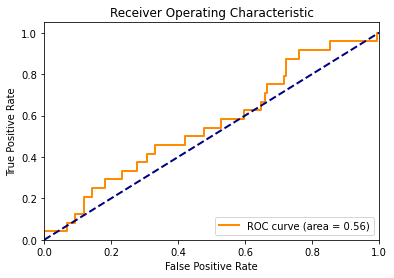

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get prediction probabilities for the positive class
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Confusion Matrix Visualization

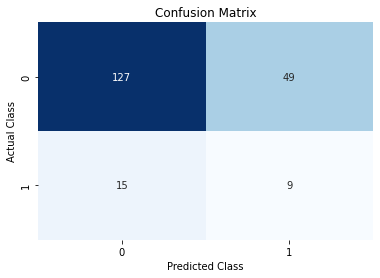

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


# Feature Importance Visualization

<Figure size 720x432 with 0 Axes>

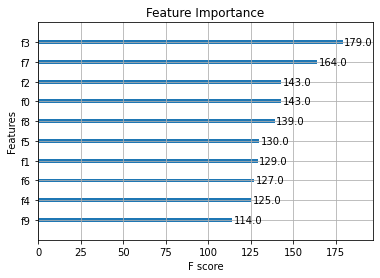

In [23]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10)
plt.title("Feature Importance")
plt.show()
